## Tabular Data 

In [1]:
import os
import itertools

import numpy as np
import pandas as pd
import polars as pl


from sklearn.preprocessing import OneHotEncoder

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## Read Data and Feature Engineering

In [2]:
root = os.getcwd()
data_root = ""
print(root)
if root.startswith("/kaggle"):
    print("True")
    # Running on kaggle notebook
    data_root  = "/kaggle/input/isic-2024-challenge/"
else:
    data_root = "isic-2024-challenge/"

train_path = data_root + 'train-metadata.csv'
test_path = data_root + 'test-metadata.csv'
subm_path = data_root + 'sample_submission.csv'


id_col = 'isic_id'
target_col = 'target'
group_col = 'patient_id'

err = 1e-5
seed = 42

num_cols = [
    'age_approx',                        # Approximate age of patient at time of imaging.
    'clin_size_long_diam_mm',            # Maximum diameter of the lesion (mm).+
    'tbp_lv_A',                          # A inside  lesion.+
    'tbp_lv_Aext',                       # A outside lesion.+
    'tbp_lv_B',                          # B inside  lesion.+
    'tbp_lv_Bext',                       # B outside lesion.+ 
    'tbp_lv_C',                          # Chroma inside  lesion.+
    'tbp_lv_Cext',                       # Chroma outside lesion.+
    'tbp_lv_H',                          # Hue inside the lesion; calculated as the angle of A* and B* in LAB* color space. Typical values range from 25 (red) to 75 (brown).+
    'tbp_lv_Hext',                       # Hue outside lesion.+
    'tbp_lv_L',                          # L inside lesion.+
    'tbp_lv_Lext',                       # L outside lesion.+
    'tbp_lv_areaMM2',                    # Area of lesion (mm^2).+
    'tbp_lv_area_perim_ratio',           # Border jaggedness, the ratio between lesions perimeter and area. Circular lesions will have low values; irregular shaped lesions will have higher values. Values range 0-10.+
    'tbp_lv_color_std_mean',             # Color irregularity, calculated as the variance of colors within the lesion's boundary.
    'tbp_lv_deltaA',                     # Average A contrast (inside vs. outside lesion).+
    'tbp_lv_deltaB',                     # Average B contrast (inside vs. outside lesion).+
    'tbp_lv_deltaL',                     # Average L contrast (inside vs. outside lesion).+
    'tbp_lv_deltaLB',                    #
    'tbp_lv_deltaLBnorm',                # Contrast between the lesion and its immediate surrounding skin. Low contrast lesions tend to be faintly visible such as freckles; high contrast lesions tend to be those with darker pigment. Calculated as the average delta LB of the lesion relative to its immediate background in LAB* color space. Typical values range from 5.5 to 25.+
    'tbp_lv_eccentricity',               # Eccentricity.+
    'tbp_lv_minorAxisMM',                # Smallest lesion diameter (mm).+
    'tbp_lv_nevi_confidence',            # Nevus confidence score (0-100 scale) is a convolutional neural network classifier estimated probability that the lesion is a nevus. The neural network was trained on approximately 57,000 lesions that were classified and labeled by a dermatologist.+,++
    'tbp_lv_norm_border',                # Border irregularity (0-10 scale); the normalized average of border jaggedness and asymmetry.+
    'tbp_lv_norm_color',                 # Color variation (0-10 scale); the normalized average of color asymmetry and color irregularity.+
    'tbp_lv_perimeterMM',                # Perimeter of lesion (mm).+
    'tbp_lv_radial_color_std_max',       # Color asymmetry, a measure of asymmetry of the spatial distribution of color within the lesion. This score is calculated by looking at the average standard deviation in LAB* color space within concentric rings originating from the lesion center. Values range 0-10.+
    'tbp_lv_stdL',                       # Standard deviation of L inside  lesion.+
    'tbp_lv_stdLExt',                    # Standard deviation of L outside lesion.+
    'tbp_lv_symm_2axis',                 # Border asymmetry; a measure of asymmetry of the lesion's contour about an axis perpendicular to the lesion's most symmetric axis. Lesions with two axes of symmetry will therefore have low scores (more symmetric), while lesions with only one or zero axes of symmetry will have higher scores (less symmetric). This score is calculated by comparing opposite halves of the lesion contour over many degrees of rotation. The angle where the halves are most similar identifies the principal axis of symmetry, while the second axis of symmetry is perpendicular to the principal axis. Border asymmetry is reported as the asymmetry value about this second axis. Values range 0-10.+
    'tbp_lv_symm_2axis_angle',           # Lesion border asymmetry angle.+
    'tbp_lv_x',                          # X-coordinate of the lesion on 3D TBP.+
    'tbp_lv_y',                          # Y-coordinate of the lesion on 3D TBP.+
    'tbp_lv_z',                          # Z-coordinate of the lesion on 3D TBP.+
]

new_num_cols = []
# categorical features
cat_cols = ['sex', 'anatom_site_general', 'tbp_tile_type', 'tbp_lv_location', 'tbp_lv_location_simple', 'attribution']
# normalisation for categorical features
norm_cols = [f'{col}_patient_norm' for col in num_cols]
# # special columns
special_cols = ['count_per_patient'] + [f'{col}_count' for col in cat_cols] + [(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)]
# combine all features
feature_cols = num_cols + cat_cols + norm_cols + special_cols

/Users/dengwenxi/Desktop/Statistical Machine Learning/Assignment/assignment3/Project


In [3]:
def read_data(path):
    return (
        pl.read_csv(path)
        .with_columns(
            pl.col('age_approx').cast(pl.String).replace('NA', np.nan).cast(pl.Float64),
        )
        .with_columns(
            pl.col(pl.Float64).fill_nan(pl.col(pl.Float64).mean()), # You may want to impute test data with train
        )
        .with_columns(
            # standardise每个患者的数值特征
            ((pl.col(col) - pl.col(col).mean().over('patient_id')) / (pl.col(col).std().over('patient_id') + err)).alias(f'{col}_patient_norm') for col in (num_cols + new_num_cols)
        )
        # feature engineering
        .with_columns(
            # generates all interaction features between numerical and categorical features
            ((pl.col(num_col) - pl.col(num_col).mean().over('patient_id', cat_col)) / (pl.col(num_col).std().over('patient_id', cat_col) + err)).alias(f'{num_col}_{cat_col}') for num_col, cat_col in itertools.product(num_cols, cat_cols)
        )
        .with_columns(
            # 计算每个患者的categorical features的出现次数
            pl.col(col).count().over('patient_id', col).alias(f'{col}_count') for col in cat_cols
        )
        .with_columns(
            # 计算每个患者的样本数 - special_cols用到
            count_per_patient = pl.col('isic_id').count().over('patient_id'),
        )
        .with_columns(
            pl.col(cat_cols).cast(pl.Categorical),
        )
        .to_pandas()
        .set_index(id_col)
    )

## Data Preprocessing and Analysis


In [4]:
def analyse_missing_values(df_train, df_test):
    # find the number of columns with missing values in df_train and df_test 
    missing_train = df_train.isnull().sum()
    missing_test = df_test.isnull().sum()

    # find out the columns with missing values
    missing_train = missing_train[missing_train > 0]
    missing_test = missing_test[missing_test > 0]
    
    print("Number of columns with missing values in df_train: ", len(missing_train))

    print("\nNumber of columns with missing values in df_test: ", len(missing_test))

    # find out the common columns with missing values in df_train and df_test
    common_missing = set(missing_train.index).intersection(set(missing_test.index))
    print("\nNumber of common columns with missing values in both df_train and df_test: ", len(common_missing))

In [5]:
def preprocess(df_train, df_test):
    global cat_cols

    # drop the columns that in df_train but not in df_test
    columns_to_drop = [col for col in df_train.columns if col not in df_test.columns and col != 'target']
    df_train = df_train.drop(columns=columns_to_drop)
    
    # Handling missing values for numerical features
    for col in num_cols + norm_cols + special_cols:
        if col in df_train.columns:
            median_value = df_train[col].mean() 
            df_train[col].fillna(median_value, inplace=True)
            df_test[col].fillna(median_value, inplace=True)
    
    # One-hot encode categorical features
    encoder = OneHotEncoder(sparse_output=False, dtype=np.int32, handle_unknown='ignore')
    encoder.fit(df_train[cat_cols])
    
    new_cat_cols = [f'onehot_{i}' for i in range(len(encoder.get_feature_names_out()))]

    df_train[new_cat_cols] = encoder.transform(df_train[cat_cols])
    df_train[new_cat_cols] = df_train[new_cat_cols].astype('category')

    df_test[new_cat_cols] = encoder.transform(df_test[cat_cols])
    df_test[new_cat_cols] = df_test[new_cat_cols].astype('category')

    for col in cat_cols:
        feature_cols.remove(col)

    feature_cols.extend(new_cat_cols)
    cat_cols = new_cat_cols

    return df_train, df_test

In [6]:
df_train = read_data(train_path)
df_test = read_data(test_path)
df_subm = pd.read_csv(subm_path, index_col=id_col)
print(df_train.shape, df_test.shape)
analyse_missing_values(df_train, df_test)

(401059, 299) (3, 288)
Number of columns with missing values in df_train:  239

Number of columns with missing values in df_test:  238

Number of common columns with missing values in both df_train and df_test:  238


In [7]:
# Preprocess the data
df_train, df_test = preprocess(df_train, df_test)

# Ensure that the columns are the same in both df_train and df_test after preprocessing
print(df_train.shape, df_test.shape)

# Ensure that there is no missing value in df_train and df_test after preprocessing
analyse_missing_values(df_train, df_test)

(401059, 336) (3, 335)
Number of columns with missing values in df_train:  0

Number of columns with missing values in df_test:  0

Number of common columns with missing values in both df_train and df_test:  0


## Define Metric

In [8]:
# partial area under the ROC curve (pAUC) above 80% true positive rate (TPR)
def pAUC(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)
    
    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])
    
    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)
    
    return partial_auc

def calculate_pAUC(estimator, X_test, y_test, scoring=None):
    if scoring:
        return scoring(estimator, X_test, y_test)
    else:
        return estimator.score(X_test, y_test)

In [9]:
# Recall = TP / (TP + FN)
# Recall represents the proportion of actual diseased cases correctly identified by the model
def calculate_recall(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    recall = tp / (tp + fn)
    return recall

def calculate_recall(estimator, X_test, y_test, scoring=None):
    if scoring:
        return scoring(estimator, X_test, y_test)
    else:
        return estimator.score(X_test, y_test)

## Tune Hyperparameters

In [10]:
# pAUC_scorer = make_scorer(pAUC, needs_proba=True)

# # Define the parameter grid
# param_grid = {
#     'logreg1__classifier__C': [0.01, 0.001, 0.0001],
#     'logreg1__classifier__solver': ['saga', 'liblinear'],
#     'logreg1__classifier__max_iter': [1000, 1500, 2000],
#     'logreg1__sampler__sampling_strategy': [0.01, 0.1]
# }

# # Create a pipeline with scaling and logistic regression
# pipeline = Pipeline([
#     ('sampler', RandomUnderSampler(random_state=12)),
#     ('scaler', StandardScaler()),
#     ('classifier', LogisticRegression(class_weight='balanced', random_state=12))
# ])

# # Create a VotingClassifier with the pipeline
# estimator = VotingClassifier([
#     ('logreg1', pipeline),
#     ('logreg2', pipeline),
#     ('logreg3', pipeline),
#     ('logreg4', pipeline)
# ], voting='soft')

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=2, scoring=pAUC_scorer, n_jobs=-1)

# X = df_train[feature_cols]
# y = df_train[target_col]
# # Fit the model
# grid_search.fit(X, y)

# # Print the best parameters and score
# print("Best parameters:", grid_search.best_params_)

In [11]:
C = 0.001
sampling_ratio = 0.01
max_iter = 1000
solver = 'saga'
sampling_ratio = 0.01

## Deine the model with best parameters

In [12]:
# Logistic Regression parameters
log_reg_params = {
    'C': C,
    'solver': solver,  
    'max_iter': max_iter,
    'class_weight': 'balanced' 
}

# Create a pipeline with scaling and logistic regression
estimator = VotingClassifier([
    ('logreg1', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=12)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(**log_reg_params, random_state=12))
    ])),
    ('logreg2', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=22)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(**log_reg_params, random_state=22))
    ])),
    ('logreg3', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=32)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(**log_reg_params, random_state=32))
    ])),
    ('logreg4', Pipeline([
        ('sampler', RandomUnderSampler(sampling_strategy=sampling_ratio, random_state=42)),
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(**log_reg_params, random_state=42))
    ])),
], voting='soft')

## Stratified K-Fold Validation

In [13]:
def stratified_k_fold_validation(X, y, estimator, k, n_repeats, scoring=None):
    scores = []
    recalls = []
    n_samples = len(y)
    unique_classes, y_indices = np.unique(y, return_inverse=True)
    class_counts = np.bincount(y_indices)
    
    # Initialize fold sizes for each class
    fold_sizes = np.zeros((len(unique_classes), k), dtype=int)
    for class_index, count in enumerate(class_counts):
        fold_sizes[class_index, :] = count // k
        fold_sizes[class_index, :count % k] += 1

    for repeat in range(n_repeats):
        indices = np.arange(n_samples)
        np.random.shuffle(indices)
        current = np.zeros(len(unique_classes), dtype=int)
        
        for fold in range(k):
            test_mask = np.zeros(n_samples, dtype=bool)
            for class_index, class_count in enumerate(class_counts):
                class_indices = indices[y_indices == class_index]
                start = current[class_index]
                stop = start + fold_sizes[class_index, fold]
                test_mask[class_indices[start:stop]] = True
                current[class_index] += fold_sizes[class_index, fold]
            
            train_idx = ~test_mask
            test_idx = test_mask
            
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y[train_idx], y[test_idx]
            
            estimator.fit(X_train, y_train)
            y_pred = estimator.predict(X_test)
            
            # Calculate the pAUC
            score = calculate_pAUC(estimator, X_test, y_test, scoring)
            scores.append(score)
            
            # Calculate recall
            recall = calculate_recall(estimator, X_test, y_test)
            recalls.append(recall)

    return np.mean(scores), scores, np.mean(recalls), recalls

In [14]:
X = df_train[feature_cols]
y = df_train[target_col]

mean_score, all_scores, mean_recall, all_recalls = stratified_k_fold_validation(
    X=X, y=y, 
    estimator=estimator, 
    k=5, n_repeats=20, 
    scoring=pAUC
)

(0.1459766115666273,
 [0.1509823257097566,
  0.13264689734947677,
  0.13563864424050345,
  0.15648619650993578,
  0.14658069798170123,
  0.1546522622627325,
  0.1297410434517372,
  0.14325445155480707,
  0.1530201502013569,
  0.15466894899095956,
  0.1613455373641555,
  0.14691514556832327,
  0.12682642296135704,
  0.14897140555109178,
  0.1542353856813994,
  0.14679247703135218,
  0.14751097338856917,
  0.1541000438507363,
  0.13886903463661898,
  0.14363388523587908,
  0.12821217932983586,
  0.17110841906324328,
  0.14002496837354753,
  0.14874975262485085,
  0.14587643165265704,
  0.15312132844368861,
  0.14223046604622802,
  0.13667526645056952,
  0.13939502629215175,
  0.1563122558907215,
  0.14348424342434746,
  0.1450090806312985,
  0.15100003653746882,
  0.1329998734373523,
  0.14689260382040017,
  0.13937304204215442,
  0.14441944292539122,
  0.1548143377839378,
  0.14195052476569614,
  0.15555150242543936,
  0.15117973738633356,
  0.12818307346668084,
  0.15548915938429317,
 

In [15]:
print(mean_score)
print(all_scores)
print(mean_recall)
print(all_recalls)

0.1459766115666273
[0.1509823257097566, 0.13264689734947677, 0.13563864424050345, 0.15648619650993578, 0.14658069798170123, 0.1546522622627325, 0.1297410434517372, 0.14325445155480707, 0.1530201502013569, 0.15466894899095956, 0.1613455373641555, 0.14691514556832327, 0.12682642296135704, 0.14897140555109178, 0.1542353856813994, 0.14679247703135218, 0.14751097338856917, 0.1541000438507363, 0.13886903463661898, 0.14363388523587908, 0.12821217932983586, 0.17110841906324328, 0.14002496837354753, 0.14874975262485085, 0.14587643165265704, 0.15312132844368861, 0.14223046604622802, 0.13667526645056952, 0.13939502629215175, 0.1563122558907215, 0.14348424342434746, 0.1450090806312985, 0.15100003653746882, 0.1329998734373523, 0.14689260382040017, 0.13937304204215442, 0.14441944292539122, 0.1548143377839378, 0.14195052476569614, 0.15555150242543936, 0.15117973738633356, 0.12818307346668084, 0.15548915938429317, 0.15227461060413328, 0.1388483726366267, 0.1425762295357353, 0.12715734277290586, 0.1563

### Analysis on validation set

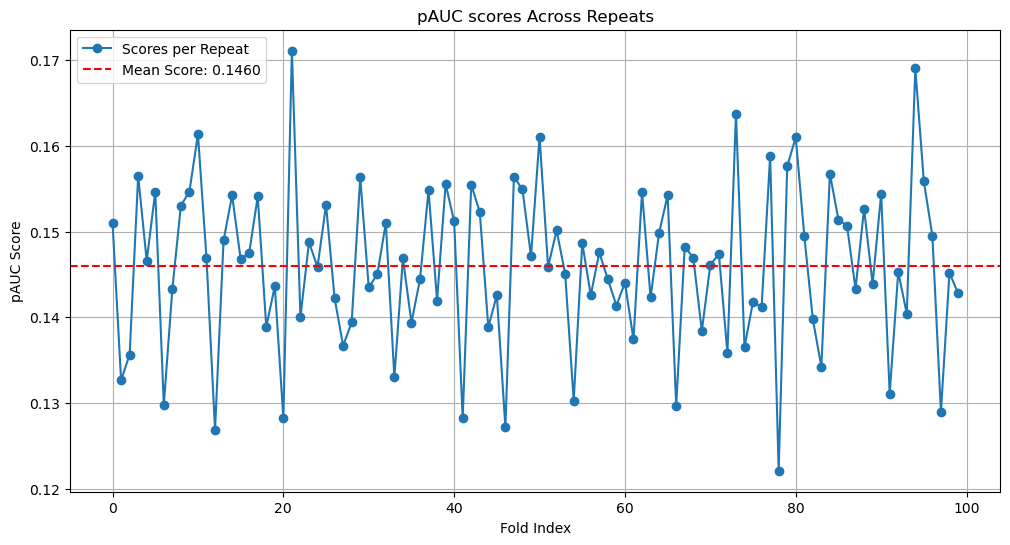

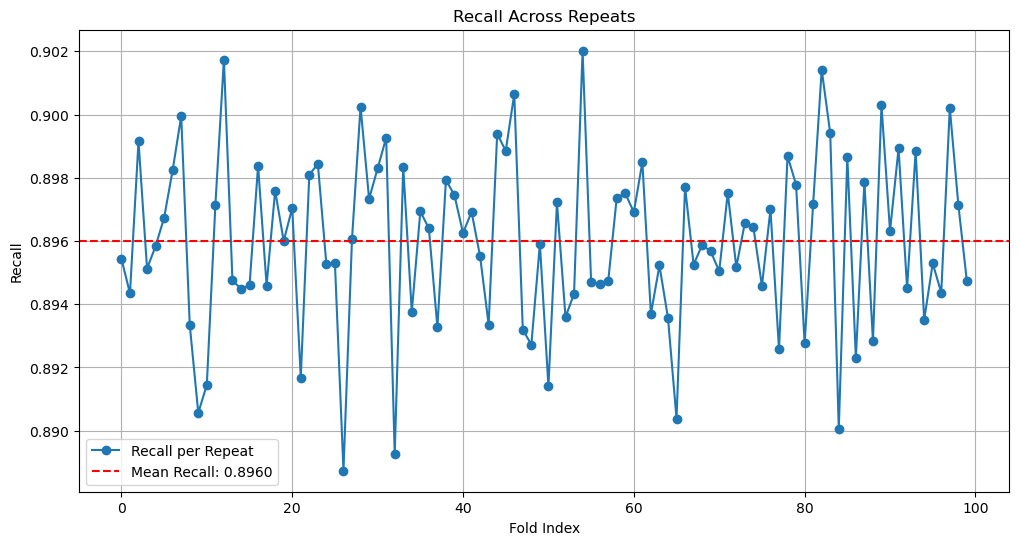

In [16]:
# For pAUC (partial area under the ROC curve)
plt.figure(figsize=(12, 6))
plt.plot(all_scores, label='Scores per Repeat', marker='o')
plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean Score: {mean_score:.4f}')
plt.title('pAUC scores Across Repeats')
plt.xlabel('Fold Index')
plt.ylabel('pAUC Score')
plt.legend()
plt.grid(True)
plt.savefig('pAUC.png')
plt.show()

# For recall
plt.figure(figsize=(12, 6))
plt.plot(all_recalls, label='Recall per Repeat', marker='o')
plt.axhline(y=mean_recall, color='r', linestyle='--', label=f'Mean Recall: {mean_recall:.4f}')
plt.title('Recall Across Repeats')
plt.xlabel('Fold Index')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.savefig('recall.png')
plt.show()

## Training

In [17]:
# X, y = df_train[feature_cols], df_train[target_col]

# estimator.fit(X, y)

VotingClassifier(estimators=[('logreg1',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=12,
                                                                  sampling_strategy=0.01)),
                                              ('scaler', StandardScaler()),
                                              ('classifier',
                                               LogisticRegression(C=0.001,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=12,
                                                                  solver='saga'))])),
                             ('logreg2',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=22,
                                                                  sampling...
                                               LogisticRegression(C=0.001,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=32,
                                                                  solver='saga'))])),
                             ('logreg4',
                              Pipeline(steps=[('sampler',
                                               RandomUnderSampler(random_state=42,
                                                                  sampling_strategy=0.01)),
                                              ('scaler', StandardScaler()),
                                              ('classifier',
                                               LogisticRegression(C=0.001,
                                                                  class_weight='balanced',
                                                                  max_iter=1000,
                                                                  random_state=42,
                                                                  solver='saga'))]))],
                 voting='soft')

## Prediction

In [18]:
# df_subm['target'] = estimator.predict_proba(df_test[feature_cols])[:, 1]

# df_subm.to_csv('submission.csv')
# df_subm.head()

,target
isic_id,
ISIC_0015657,0.152777
ISIC_0015729,0.105351
ISIC_0015740,0.177142
